<a href="https://colab.research.google.com/github/Vedikaaa-737/SKILL/blob/main/DS_BOT_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import zipfile

uploaded = files.upload()

with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('data')

print("Files extracted:")
!ls data

Saving LCA_DATASET.ZIP.zip to LCA_DATASET.ZIP.zip
Files extracted:
LCA_DATASET


In [7]:
#LOAD AND MERGE DATASET

import pandas as pd

file_paths = [
    '/content/data/LCA_DATASET/UNSW_2018_IoT_Botnet_Dataset_1.csv',
    '/content/data/LCA_DATASET/UNSW_2018_IoT_Botnet_Dataset_2.csv',
    '/content/data/LCA_DATASET/UNSW_2018_IoT_Botnet_Dataset_3.csv',
    '/content/data/LCA_DATASET/UNSW_2018_IoT_Botnet_Dataset_4.csv'
]

dfs = [pd.read_csv(f, nrows=30000) for f in file_paths]  # 30K rows per file
merged_df = pd.concat(dfs, ignore_index=True)
print(f"✅ Merged {len(merged_df)} rows")
print("Columns:", merged_df.columns.tolist())

<ipython-input-7-f2cc3e80991d>:13: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(f, nrows=30000) for f in file_paths]  # 30K rows per file


✅ Merged 120000 rows
Columns: ['1', '1526344121.188091', 'e', 'arp', '192.168.100.1', 'Unnamed: 5', '192.168.100.3', 'Unnamed: 7', '4', '240', 'CON', '1526345317.184693', '9', '1195.996582', '0.000006', '0.000002', 'Unnamed: 16', 'Unnamed: 17', '0.000011', '0.000004', '0.000007', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', '2', '2.1', '120', '120.1', '0.002508', '0.000836', '0.000836.1', '0', 'Normal', 'Normal.1', '1000001', '1526949252.645504', 'tcp', '192.168.100.150', '49731', '41081', 'RST', '1526949252.687410', '180408', '0.041906', '0.041906.1', '0.041906.2', '0.041906.3', '0.041906.4', '1.1', '60', '60.1', '23.862932', '0.1', '0.2', '1.2', 'Reconnaissance', 'Service_Scan', '2000001', '1528081325.528940', 'e s', '192.168.100.149', '30117', '192.168.100.5', '80', '616', 'REQ', '1528081352.858893', '140143', '27.329952', '0.3', '0.4', '4.1', '0.5', '616.1', '0.6', '0.10977', '0.10977.1', '0.7', 'DoS', 'TCP', '3000001', '1528081523.621591', '54919', '3', '462', '1528

In [11]:
#column mapping for dataset
COLUMNS = {
    'timestamp': '1526344121.188091',
    'protocol': 'tcp',                # Found in row 2
    'src_ip': '192.168.100.150',      # Found in row 2
    'dst_ip': '41081',                # Found in row 2
    'duration': '0.041906',           # Found in row 2
    'bytes': '180408',                # Found in row 2
    'label': 'Reconnaissance'         # Found in row 2
}

# Create clean dataframe
df = merged_df[[
    '1526344121.188091',  # timestamp
    'tcp',                # protocol
    '192.168.100.150',    # src_ip
    '41081',              # dst_ip
    '0.041906',           # duration
    '180408',             # bytes
    'Reconnaissance'      # label
]].copy()

# Rename columns
df.columns = ['timestamp', 'protocol', 'src_ip', 'dst_ip', 'duration', 'bytes', 'label']

In [12]:

print(f"Dataset shape: {df.shape}")

Dataset shape: (120000, 7)


In [13]:
#Data Cleaning

#only valid protocols
df = df[df['protocol'].isin(['tcp','udp','arp'])]

# Clean missing values
df = df.dropna(subset=['duration', 'bytes'])

print(f"Cleaned shape: {df.shape}")

Cleaned shape: (30000, 7)


In [14]:
#ENCODING

from sklearn.preprocessing import LabelEncoder

# Protocol encoding
df['protocol_encoded'] = LabelEncoder().fit_transform(df['protocol'])

# Label encoding
df['is_attack'] = df['label'].apply(lambda x: 0 if x == 'Normal' else 1)

In [15]:
#NORMALIZATION

from sklearn.preprocessing import MinMaxScaler

df[['duration', 'bytes']] = MinMaxScaler().fit_transform(df[['duration', 'bytes']])

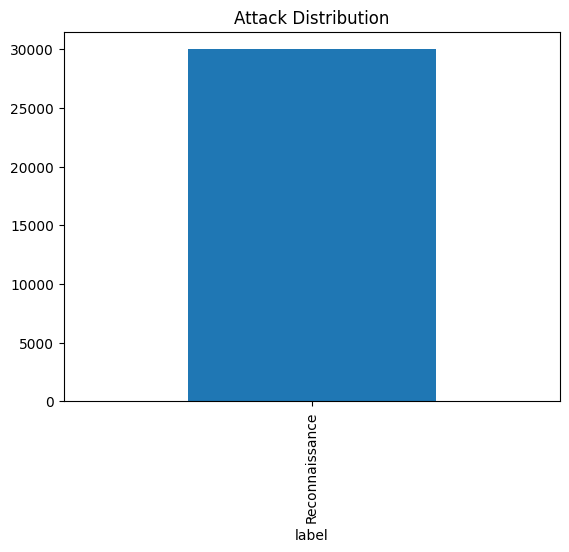

In [16]:
#UNIVARIATE PLOTS

import matplotlib.pyplot as plt

# Attack distribution
df['label'].value_counts().plot(kind='bar')
plt.title("Attack Distribution")
plt.show()

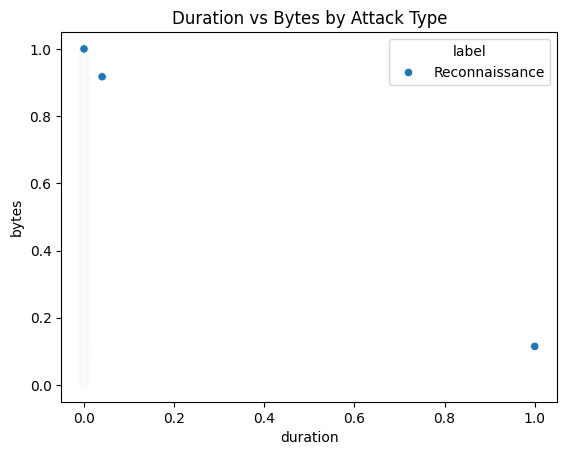

In [17]:
#MULTIVARIATE PLOTS

import seaborn as sns

sns.scatterplot(data=df, x='duration', y='bytes', hue='label')
plt.title("Duration vs Bytes by Attack Type")
plt.show()

In [28]:
import pandas as pd
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    RFE,
    SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

#Data
data = {
    'duration': [1.2, 0.5, 3.1, 0.8, 1.5],
    'bytes': [100, 1500, 300, 800, 1200],
    'protocol': ['tcp', 'udp', 'tcp', 'arp', 'udp'],
    'label': ['Normal', 'Attack', 'Attack', 'Normal', 'Attack']
}
df = pd.DataFrame(data)

#Preprocessing
X = df[['duration', 'bytes']].copy()
X['protocol'] = LabelEncoder().fit_transform(df['protocol'])
y = df['label'].apply(lambda x: 1 if x == 'Attack' else 0)  # Binary target

# FILTER METHOD (ANOVA)
selector = SelectKBest(f_classif, k=2)
X_filtered = selector.fit_transform(X, y)
print("ANOVA Selected Features:", X.columns[selector.get_support()].tolist())

ANOVA Selected Features: ['bytes', 'protocol']


In [30]:
#WRAPPER METHOD (RFE)
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=2)
X_wrapped = selector.fit_transform(X, y)
print("\nRFE Selected Features:", X.columns[selector.get_support()].tolist())



RFE Selected Features: ['duration', 'protocol']


In [31]:
#EMBEDDED METHOD (RF Importance)
selector = SelectFromModel(RandomForestClassifier(n_estimators=50))
X_embedded = selector.fit_transform(X, y)
print("\nRF Important Features:", X.columns[selector.get_support()].tolist())


RF Important Features: ['duration', 'protocol']


Current columns: ['duration', 'bytes', 'protocol', 'label', 'protocol_encoded', 'is_attack']

Train samples: 3, Test samples: 2

=== Random Forest ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



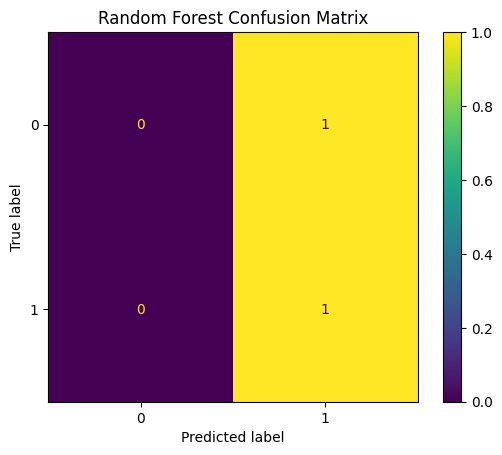


=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



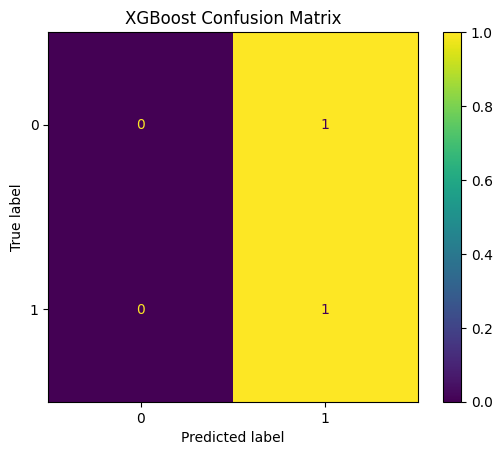


Model saved as 'botnet_classifier.pkl'


In [40]:
#IMPORT LIBRARIES
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# DATA PREPARATION
print("Current columns:", df.columns.tolist())

# Feature Engineering
df['protocol_encoded'] = LabelEncoder().fit_transform(df['protocol'])
df['is_attack'] = df['label'].apply(lambda x: 1 if x != 'Normal' else 0)

# Select Final Features
X = df[['duration', 'bytes', 'protocol_encoded']]
y = df['is_attack']

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print(f"\nTrain samples: {len(X_train)}, Test samples: {len(X_test)}")

#CLASSIFIER TRAINING
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier()
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

#MODEL SAVING
joblib.dump(models["Random Forest"], 'botnet_classifier.pkl')
print("\nModel saved as 'botnet_classifier.pkl'")

In [41]:
# Save all necessary files
!mkdir -p botnet_project  # Create project folder
%cd botnet_project

# 1. Save processed data
df.to_csv('processed_data.csv', index=False)

# 2. Save the trained model
joblib.dump(models["Random Forest"], 'model.pkl')

# 3. Save requirements
!pip freeze > requirements.txt

# 4. Save notebook with outputs
from google.colab import files
!jupyter nbconvert --to html /content/Your_Notebook.ipynb
!cp /content/Your_Notebook.html .

# 5. Create README.md
with open('README.md', 'w') as f:
    f.write("""# IoT Botnet Detection Project

## Files Included
- `processed_data.csv`: Cleaned dataset
- `model.pkl`: Trained Random Forest model
- `Your_Notebook.html`: Full executed notebook
- `requirements.txt`: Python dependencies

## How to Use
1. Clone this repository
2. Install requirements: `pip install -r requirements.txt`
3. Load model:
```python
import joblib
model = joblib.load('model.pkl')
```""")

# Compress everything
!zip -r ../botnet_project.zip *
%cd ..
files.download('botnet_project.zip')

/content/botnet_project
[NbConvertApp] WARNING | pattern '/content/Your_Notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupyte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>